# Análisis para la empresa CallMeMaybe
## Preparación y Comprensión del Problema 
Uno de los grandes avances de la tecnología tiene que ver con la evolución de la telefonía tradicional a la telefonía móvil. Mientras antes era necesario que los teléfonos fuera fijos y que estos estuvieran fijos, gracias al desarrollo de la telefonía móvil, la posibilidad de comunicarse sin necesidad de conectarse a cables **<small>1</small>**. Esto no solo ha incrementado la comunicación entre personas, sino que también ha cambiado la forma en que los operadores de un callcenter llevan a cabo su trabajo pues pueden incrementar el número de llamadas realizadas y respondidas, pero también pueden recibir un mayor número de llamadas, pues ya no está la necesidad de "estar atados" a una conexión para comunicarse y ahora podemos hacerlo desde cualquier parte. 

Esto, indudablemente ha facilitado la creación de empresas como CallMeMaybe un servicio de telefonía virtual que está buscando verificar la eficacia de sus operadores. Derivado de la alta cantidad de Call Centers que existen hoy en día - por ejemplo, tan solo en México existen mas de 300 centros  **<small>2</small>** - es necesario que los centros constantemente evalúen su eficiencia para garantizar ser lo suficientemente competitivos y atractivos para quienes buscan en apoyo de estos. Existen diversos indicadores clave para determinar que tan eficiente es un call center, tales como  **<small>3</small>**: 

- Tiempo medio de abandono: es decir, el porcentaje de llamadas en los que los clientes cuelgan antes de hablar con un operador. También se les conoce como llamadas perdidas. En teoría **una tasa de abandono normal está dentro del 2% al 5%**, si se supera dicho porcentaje resulta importante investigar la causa. 
- Tiempo medio de espera: el tiempo que los clientes esperan antes de ser atendidos por un agentes. Como tal no existe un rango aceptable de tiempo de espera, lo ideal es que sea el menor tiempo posible, sin embargo por lo general se aplica la regla 80/20 donde el 80% de las llamadas deben contestarse en 20 segundos **<small>4</small>** . Por otra parte, es importante mencionar que el 44% de los usuarios se sienten inconformes con un tiempo de espera de entre 5 a 15 minutos. Finalmente, la fórmula para calcularlo es dividir el total de tiempo de espera entre el numero de llamadas  **<small>5</small>**.
- Número de llamadas realizadas: el promedio de de llamadas realizadas dependerá de los datos de la empresa, sin embargo este puede mejorar - en caso de considerarse necesario - analizando los motivos de un promedio bajo de llamadas. Es importante mencionar que en promedio un agente llevará a cabo 46 llamadas al día  **<small>6</small>**.

Tomando en cuenta el contexto y los datos anteriores, llevaremos a cabo un análisis de datos proporcionados por la empresa CallMeMaybe a fin de identificar a los operadores más eficaces y a los operadores ineficaces considerando las métricas previamente descritas. 
Para ello, llevaremos a cabo las siguientes actividades: 

1. Recolección y preparación de datos: donde cargaremos, limpiaremos y pre-procesaremos nuestros datasets para dejarlos listos para su análisis.
2. Análisis exploratorio de datos: donde identificaremos patrones y anomalías iniciales, consideraremos factores como: distribución de la duración de las llamadas, comparación entre llamadas internas y llamadas externas, analizaremos las llamadas entrantes y salientes por días, detectaremos valores atípicos e identificaremos si existen correlaciones entre las variables.
3. Identificación de operadores ineficaces: Llevaremos a cabo el cálculo y la comparación de nuestras métricas por el operator_id, agregando visualizaciones que muestren el resultado de nuestros hallazgos.
4. Prueba de hipótesis estadística: Desarrollaremos hipótesis con base en nuestros hallazgos, y llevaremos a cabo pruebas para confirmar o rechazar nuestras hipótesis.
5. Visualización: Crearemos Dashboards que nos permitan ver de forma clara e interactiva los hallazgos identificados.
6. Presentación final: haremos una síntesis de nuestro proyecto, resaltando los hallazgos más relevantes de cada sección.

### 1. Recolección y preparación de datos: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

df_calls = pd.read_csv('/datasets/telecom_dataset_us.csv')
df_clients = pd.read_csv('/datasets/telecom_clients_us.csv')

#### Preprocesamiento del DF 'telecom_dataset_us.csv'

In [2]:
df_calls.info()
print(df_calls.head(20))

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 53902 entries, 0 to 53901
,Data columns (total 9 columns):
, #   Column               Non-Null Count  Dtype  
,---  ------               --------------  -----  
, 0   user_id              53902 non-null  int64  
, 1   date                 53902 non-null  object 
, 2   direction            53902 non-null  object 
, 3   internal             53785 non-null  object 
, 4   operator_id          45730 non-null  float64
, 5   is_missed_call       53902 non-null  bool   
, 6   calls_count          53902 non-null  int64  
, 7   call_duration        53902 non-null  int64  
, 8   total_call_duration  53902 non-null  int64  
,dtypes: bool(1), float64(1), int64(4), object(3)
,memory usage: 3.3+ MB
,    user_id                       date direction internal  operator_id  \
,0    166377  2019-08-04 00:00:00+03:00        in    False          NaN   
,1    166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
,2    166377  2019-08-05 00:00:

De este primer vistazo a los datos, podemos ver los siguientes detalles: 
1. Es necesario ajustar los tipos de datos
2. El 15% (es decir, 8,172 registros) de nuestros valores de la columna 'operator_id' están vacías. 

Con base en estos hallazgos las líneas de acción a seguir con el DataFrame son: 
1. Ajustar los tipos de datos
2. Identificar por qué hay valores ausentes en la columna operator_id, y determinar cómo procesarlos. 

In [3]:
df_calls['user_id'] = df_calls['user_id'].astype('object')
df_calls['date'] = pd.to_datetime(df_calls['date'])
df_calls['internal'] = df_calls['internal'].astype('bool')
df_calls['operator_id'] = df_calls['operator_id'].apply(lambda x:str(int(x)) if pd.notna(x)else x)
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 53902 entries, 0 to 53901
,Data columns (total 9 columns):
, #   Column               Non-Null Count  Dtype                                
,---  ------               --------------  -----                                
, 0   user_id              53902 non-null  object                               
, 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
, 2   direction            53902 non-null  object                               
, 3   internal             53902 non-null  bool                                 
, 4   operator_id          45730 non-null  object                               
, 5   is_missed_call       53902 non-null  bool                                 
, 6   calls_count          53902 non-null  int64                                
, 7   call_duration        53902 non-null  int64                                
, 8   total_call_duration  53902 non-null  int64                                

In [4]:
df_in_missed_noperator = df_calls[
    (df_calls['direction'] == 'in') &
    (df_calls['operator_id'].isna())&
    (df_calls['is_missed_call'])
]
print(df_in_missed_noperator)

df_in_noperator = df_calls[
    (df_calls['direction'] == 'in') &
    (df_calls['operator_id'].isna())&
    (df_calls['is_missed_call'] == False)
]
print(df_in_noperator)

      user_id                      date direction  internal operator_id  \
,0      166377 2019-08-04 00:00:00+03:00        in     False         NaN   
,7      166377 2019-08-05 00:00:00+03:00        in     False         NaN   
,9      166377 2019-08-06 00:00:00+03:00        in     False         NaN   
,17     166377 2019-08-07 00:00:00+03:00        in     False         NaN   
,27     166377 2019-08-12 00:00:00+03:00        in     False         NaN   
,...       ...                       ...       ...       ...         ...   
,53876  168601 2019-11-27 00:00:00+03:00        in     False         NaN   
,53880  168601 2019-11-28 00:00:00+03:00        in     False         NaN   
,53889  168603 2019-11-28 00:00:00+03:00        in     False         NaN   
,53893  168606 2019-11-08 00:00:00+03:00        in     False         NaN   
,53901  168606 2019-11-19 00:00:00+03:00        in     False         NaN   
,
,       is_missed_call  calls_count  call_duration  total_call_duration  
,0           

De esta primera identificación, podemos observar que 7,899 registros corresponden a llamadas entrantes perdidas, por lo que es lógico que no cuenten con un número de operador.  

Por otra parte, identificamos 73 llamadas que parecen tener un error en registro, pues si fueron atendidas pero no se asigno ningún número de operador.

In [5]:
df_out_missed_noperator = df_calls[
    (df_calls['direction'] == 'out') & 
    (df_calls['operator_id'].isna()) &
    (df_calls['is_missed_call'])
]

print(df_out_missed_noperator)

df_out_noperator = df_calls[
    (df_calls['direction'] == 'out') & 
    (df_calls['operator_id'].isna()) &
    (df_calls['is_missed_call'] == False)
]

df_out_noperator.info()

      user_id                      date direction  internal operator_id  \
,455    166377 2019-11-06 00:00:00+03:00       out     False         NaN   
,2402   166407 2019-10-10 00:00:00+03:00       out      True         NaN   
,3241   166485 2019-10-15 00:00:00+03:00       out      True         NaN   
,3271   166485 2019-10-18 00:00:00+03:00       out      True         NaN   
,3276   166485 2019-10-18 00:00:00+03:00       out      True         NaN   
,...       ...                       ...       ...       ...         ...   
,53095  168361 2019-11-27 00:00:00+03:00       out     False         NaN   
,53247  168412 2019-11-07 00:00:00+03:00       out     False         NaN   
,53381  168412 2019-11-22 00:00:00+03:00       out     False         NaN   
,53400  168412 2019-11-25 00:00:00+03:00       out     False         NaN   
,53417  168412 2019-11-26 00:00:00+03:00       out     False         NaN   
,
,       is_missed_call  calls_count  call_duration  total_call_duration  
,455         

De esta segunda validación podemos idnetificar que 151 corresponden a llamadas salientes que no fueron atendidas y 49 también caen en el error de registro ya que si bien, fueron llamadas que se completaron, su registro no fue completo ni correcto ya que no se incorporó el dato de operator_id. 

En ese sentido, toda vez que el objetivo del análisis es evaluar la eficacia de los operadores con base en métricas individuales (cantidad de llamadas perdidas, tiempo de espera promedio y número de llamadas salientes realizadas), los registros sin 'operator_id' no aportan información relevante para este propósito ya que no puede vincularse a ningún operador en particular. Es importante mencionar que también sería arbitrario asignar registros a los operadores sin algún estandar aparente y podría beneficiar o perjudicar las metricas de cada operador. 

Por ello, se decidió excluir los registros sin 'operator_id' del análisis principal por desempeño individual, sin embargo se conservarán por separado en caso de que resulten ser útiles para estudios complementarios sobre la eficiencia general de la empresa.

In [6]:
df_calls_clean = df_calls.dropna().reset_index()
df_calls_clean.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 45730 entries, 0 to 45729
,Data columns (total 10 columns):
, #   Column               Non-Null Count  Dtype                                
,---  ------               --------------  -----                                
, 0   index                45730 non-null  int64                                
, 1   user_id              45730 non-null  object                               
, 2   date                 45730 non-null  datetime64[ns, pytz.FixedOffset(180)]
, 3   direction            45730 non-null  object                               
, 4   internal             45730 non-null  bool                                 
, 5   operator_id          45730 non-null  object                               
, 6   is_missed_call       45730 non-null  bool                                 
, 7   calls_count          45730 non-null  int64                                
, 8   call_duration        45730 non-null  int64                               

Ahora que tenemos nuestro DatFrame ajustado, podemos continuar con el pre-procesamieno de nuestro otro 

#### Preprocesamiento del DF 'telecom_clients_us'

In [7]:
df_clients.info()
print(df_clients.head(20))

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 732 entries, 0 to 731
,Data columns (total 3 columns):
, #   Column       Non-Null Count  Dtype 
,---  ------       --------------  ----- 
, 0   user_id      732 non-null    int64 
, 1   tariff_plan  732 non-null    object
, 2   date_start   732 non-null    object
,dtypes: int64(1), object(2)
,memory usage: 17.3+ KB
,    user_id tariff_plan  date_start
,0    166713           A  2019-08-15
,1    166901           A  2019-08-23
,2    168527           A  2019-10-29
,3    167097           A  2019-09-01
,4    168193           A  2019-10-16
,5    167764           A  2019-09-30
,6    167050           A  2019-08-29
,7    168252           A  2019-10-17
,8    168495           A  2019-10-28
,9    167879           A  2019-10-03
,10   168573           A  2019-10-31
,11   166610           A  2019-08-12
,12   167536           A  2019-09-19
,13   168354           A  2019-10-23
,14   168284           A  2019-10-20
,15   168422           A  2019-10-24
,1

Para este DataFrame solo ajustaremos nuestros tipos de datos. 

In [8]:
df_clients['user_id'] = df_clients['user_id'].astype('object')
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 732 entries, 0 to 731
,Data columns (total 3 columns):
, #   Column       Non-Null Count  Dtype         
,---  ------       --------------  -----         
, 0   user_id      732 non-null    object        
, 1   tariff_plan  732 non-null    object        
, 2   date_start   732 non-null    datetime64[ns]
,dtypes: datetime64[ns](1), object(2)
,memory usage: 17.3+ KB


Por último, uniremos nuestros dos DataFrames para tener la información en solo una base de datos. 

In [9]:
df_full = df_calls.merge(df_clients, on='user_id',how='left')
df_full['waiting_time'] = df_full['total_call_duration'] - df_full['call_duration']
df_full.info()
df_full.head()

<class 'pandas.core.frame.DataFrame'>
,Int64Index: 53902 entries, 0 to 53901
,Data columns (total 12 columns):
, #   Column               Non-Null Count  Dtype                                
,---  ------               --------------  -----                                
, 0   user_id              53902 non-null  object                               
, 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
, 2   direction            53902 non-null  object                               
, 3   internal             53902 non-null  bool                                 
, 4   operator_id          45730 non-null  object                               
, 5   is_missed_call       53902 non-null  bool                                 
, 6   calls_count          53902 non-null  int64                                
, 7   call_duration        53902 non-null  int64                                
, 8   total_call_duration  53902 non-null  int64                               

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,waiting_time
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,B,2019-08-01,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,B,2019-08-01,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,B,2019-08-01,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,B,2019-08-01,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,B,2019-08-01,25


#### Conclusiones
Se identificaron celdas vacías en el campo 'operator_id', lo cual impide que se vinculen los eventos que son objetos de nuestras métricas a los operadores. Por ello, se tomó la decisión de excluir dichos datos de nuestro análisis.

En ambos casos fue necesario ajustar el tipo de los datos de diversos campos. Una vez realizados dichos ajustes, las bases de datos están listos para iniciar con el análisis exploratorio de datos. 

### 2. Análisis Exploratorio de Datos

#### 2.1. Distribución en la duración de llamadas
##### 2.1.1 Histograma duración tiempo de esperas de llamadas (entrantes y salientes)

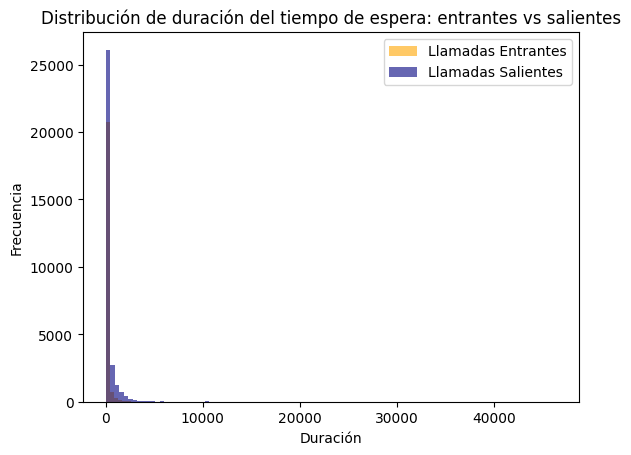

In [10]:
df_in = df_full[df_full['direction'] == 'in']
df_out = df_full[df_full['direction'] == 'out']

plt.hist(df_in['waiting_time'], bins=100, alpha=0.6, label='Llamadas Entrantes', color='orange')
plt.hist(df_out['waiting_time'], bins=100, alpha=0.6, label='Llamadas Salientes', color='navy')

plt.title('Distribución de duración del tiempo de espera: entrantes vs salientes')
plt.xlabel('Duración')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

De esta primera comparación entre llamadas salientes y entrantes, podemos identificar que el tiempo de espera de las llamadas entrantes y salientes, en su mayoría se situa en un rango de 1 minuto. Esto es una buena señal, especialmente para las llamadas entrantes, pues no se hace esperar mucho a los clientes para comunicarse con un operador. 

Asimismo, podemos idnetificar que hay valores atípicos, pero estos pueden corresponder a los valores agrupados (para aquellos casos en los que calls_count sea mayor a 1). Hagamos una segunda verificación para ver con mayor detalle la distribución de los tiempos de espera. 

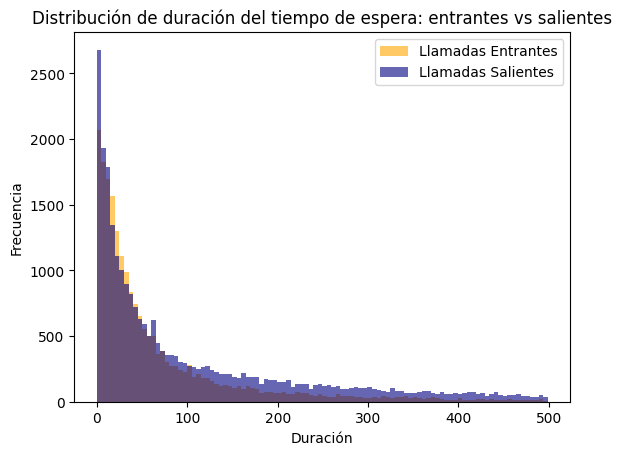

In [11]:
df_in_normal = df_in[df_in['waiting_time'] < 500]
df_out_normal = df_out[df_out['waiting_time'] < 500]

plt.hist(df_in_normal['waiting_time'], bins=100, alpha=0.6, label='Llamadas Entrantes', color='orange')
plt.hist(df_out_normal['waiting_time'], bins=100, alpha=0.6, label='Llamadas Salientes', color='navy')

plt.title('Distribución de duración del tiempo de espera: entrantes vs salientes')
plt.xlabel('Duración')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Podemos identificar que la mayor cantidad de llamadas tienen un tiempo de espera de 0 a 60 segundos, particularmente las llamadas entrantes tienen menor tiempo de espera que las llamadas salientes. 

Ahora comparemos la duración de nuestras llamadas. 

##### 2.1.2 Histograma de la duración de llamadas atendidas (entrantes y salientes)

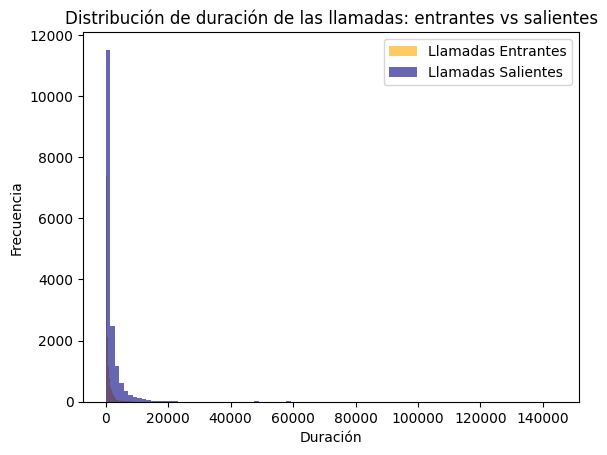

In [12]:
df_in_talk = df_in[df_in['call_duration'] > 0]
df_out_talk = df_out[df_out['call_duration'] > 0]

plt.hist(df_in_talk['call_duration'], bins=100, alpha=0.6, label='Llamadas Entrantes', color='orange')
plt.hist(df_out_talk['call_duration'], bins=100, alpha=0.6, label='Llamadas Salientes', color='navy')

plt.title('Distribución de duración de las llamadas: entrantes vs salientes')
plt.xlabel('Duración')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Podemos identificar que en general las llamadas salientes tienden a tener una duración mayor que las llamadas entrantes. Por una parte esto podría ser un indicador de que los operadores están lo suficientemente capacitados para atender las necesidades de los clientes que llaman, motivo por el cual las llamadas son significativamente más cortas. Por otra parte, esto podría ser un indicador de que los operadores logran retener la atención de los clientes a los que llaman, por lo que es algo positivo que las llamadas salientes sean más largas que las entrantes. 

También identificamos valores atípicos que pueden estar relacionadas con los valores agrupados. Tratemos de graficar nuevamente retirando los valores atípicos. 

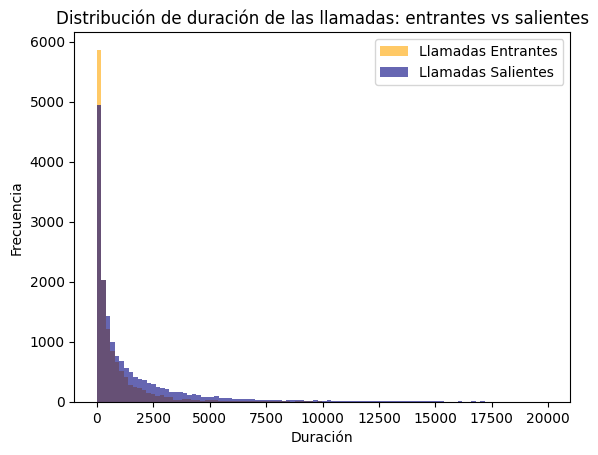

In [13]:
df_in_talk = df_in[
    (df_in['call_duration'] > 0) &
    (df_in['call_duration'] < 20000)
    ]
df_out_talk = df_out[
    (df_out['call_duration'] > 0) &
    (df_out['call_duration'] < 20000)
    ]

plt.hist(df_in_talk['call_duration'], bins=100, alpha=0.6, label='Llamadas Entrantes', color='orange')
plt.hist(df_out_talk['call_duration'], bins=100, alpha=0.6, label='Llamadas Salientes', color='navy')

plt.title('Distribución de duración de las llamadas: entrantes vs salientes')
plt.xlabel('Duración')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Con esta nueva perspectiva podemos observar que la gran mayoría de las llamadas entrantes duran poco más de 0 segundos. De igual manera, las llamadas salientes suelen duran poco más de 0 segundos, pero hay una mayor tendencia a que duren más. 

Ya que analizamos el comportamiento de las llamadas entrantes en comparación con el de las llamadas salientes, ahora comparemos el porcentaje de cada una de ellas que se reciben. 

#### 2.2. Comparación de llamadas externas e internas


In [14]:
call_counts = df_full['direction'].value_counts()
print(call_counts)

out    31917
,in     21985
,Name: direction, dtype: int64


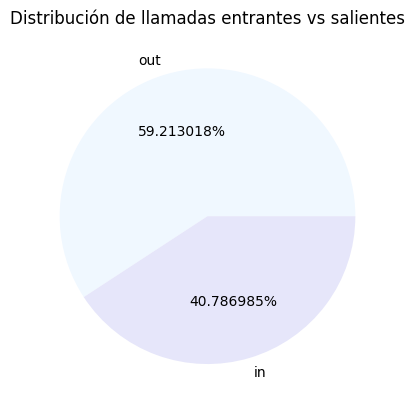

In [15]:
plt.pie(call_counts, labels = call_counts.index, autopct='%-1f%%', colors=['aliceblue', 'lavender'])
plt.title('Distribución de llamadas entrantes vs salientes')
plt.show()

Podemos observar que se llevaron a cabo una mayor cantidad de llamadas salientes que entrantes. Ahora veamos cuantas de nuestras llamadas salientes son externas (True) y cuantas son internas (False)

False    26483
,True      5434
,Name: internal, dtype: int64


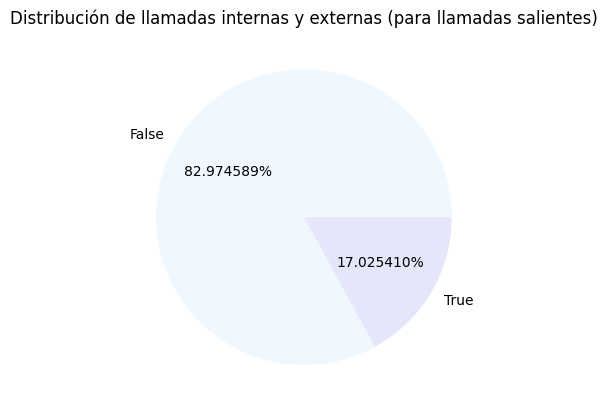

In [16]:
out_internal_count = df_out['internal'].value_counts()
print(out_internal_count)
plt.pie(out_internal_count, labels=out_internal_count.index, autopct='%-1f%%', colors=['aliceblue', 'lavender'])
plt.title('Distribución de llamadas internas y externas (para llamadas salientes)')
plt.show()

De nuestro total de llamadas salientes el 82% de ellas corresponden a llamadas externas. Esto es importante, pues indica un número significativo de llamadas de operadores con clientes.  

Ahora identifiquemos en que categoría caen la mayoría de las llamadas salientes. 

False    26483
,True      5434
,Name: internal, dtype: int64


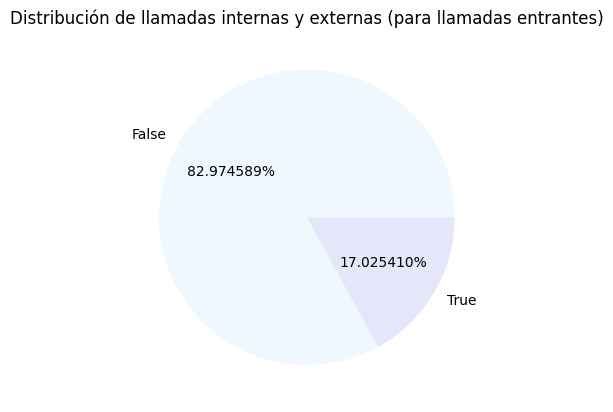

In [17]:
in_internal_count = df_in['internal'].value_counts()
print(in_internal_count)
plt.pie(in_internal_count, labels=in_internal_count.index, autopct='%-1f%%', colors=['aliceblue', 'lavender'])
plt.title('Distribución de llamadas internas y externas (para llamadas entrantes)')
plt.show()

Al igual que para las llamadas salientes, la mayoría de las llamadas entrantes corresponden a llamadas externas. 

Esto nos habla de un comportamiento "sano" pues aparentemente los operadores se centran en la comunicación con los clientes.

#### 2.3. Cantidad de llamadas entrantes y salientes por día 
##### 2.3.1. Actividad de llamadas 


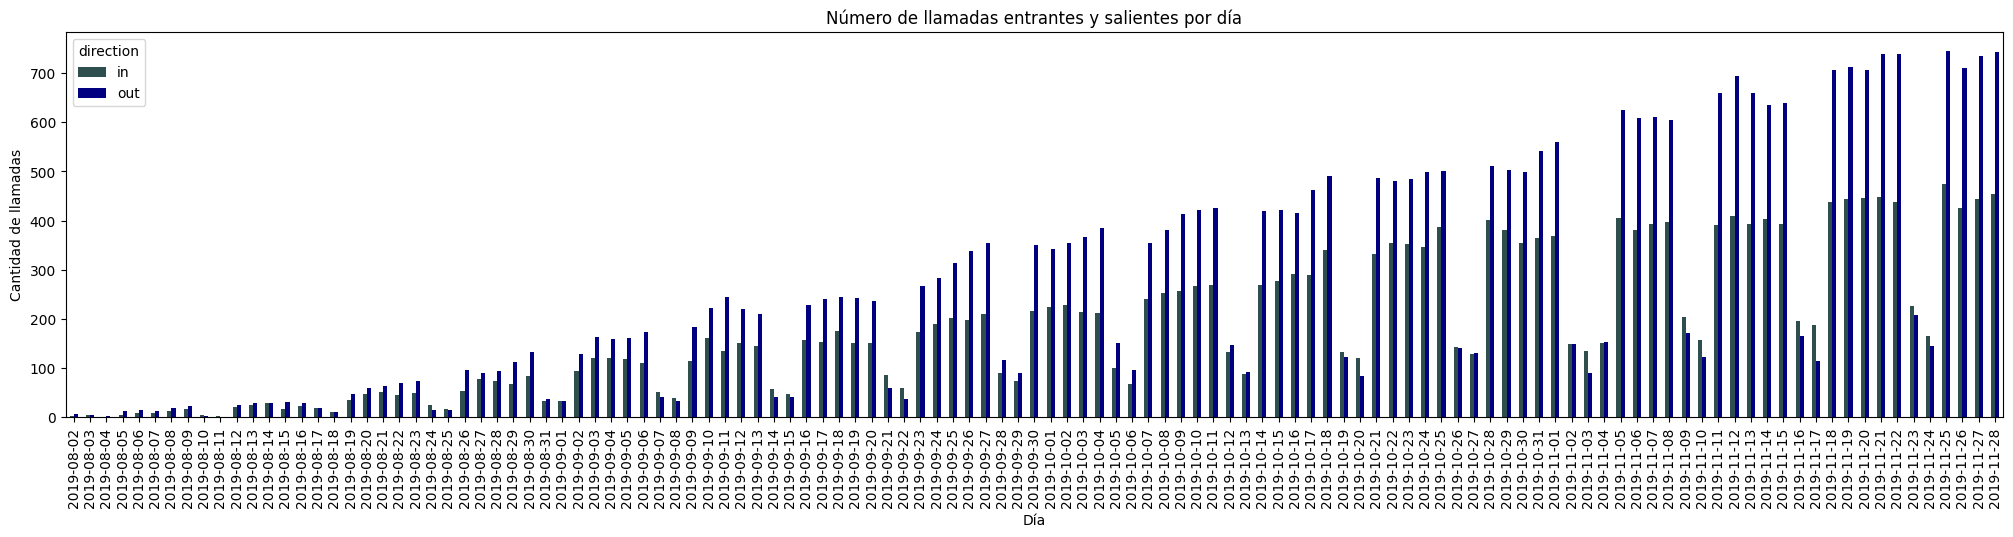

In [18]:
df_full['day'] = df_full['date'].dt.date
calls_per_day = df_full.groupby(['day','direction']).size().unstack(fill_value=0)
calls_per_day.plot(kind='bar', figsize=(25,5), color=['darkslategray', 'navy'])
plt.title('Número de llamadas entrantes y salientes por día')
plt.xlabel('Día')
plt.ylabel('Cantidad de llamadas')
plt.show()

De esta gráfica podemos identificar que el numero de llamadas salientes y entrantes ha incrementado, lo cual puede deberse a la incorporación de nuevos operadores en el estudio. 

Ahora bien, esta gráfica muestra la cantidad de llamadas realizadas, incluso si estas no fueron atendidas, por lo que sería interesante ver el comportamiento únicamente de las llamadas en las que si hubo una conversación y que esta haya sido con clientes. 

##### 2.3.2. Conversaciones reales con clientes

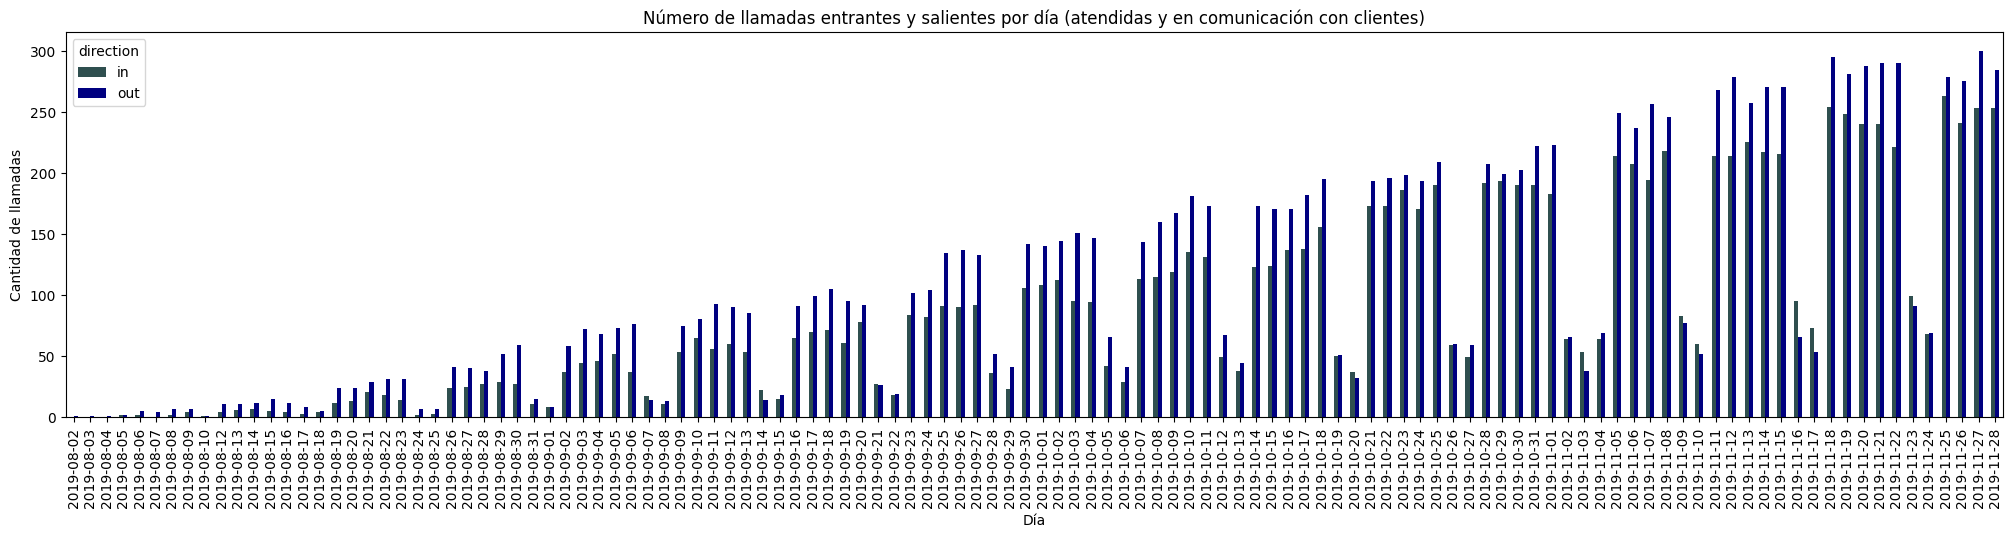

In [19]:
df_talk = df_full[
    (df_full['call_duration']>60) &
    (df_full['internal'] == False)]
call_talk_per_day = df_talk.groupby(['day','direction']).size().unstack(fill_value=0)
call_talk_per_day.plot(kind='bar', figsize=(25,5), color=['darkslategray', 'navy'])
plt.title('Número de llamadas entrantes y salientes por día (atendidas y en comunicación con clientes)')
plt.xlabel('Día')
plt.ylabel('Cantidad de llamadas')
plt.show()

De esta segunda gráfica, podemos identificar que el número de llamadas atendidas y con clientes se reduce significativamente (menos de la mitad de las llamadas totales). 

Asimismo, podemos identificar que hay días con mayor actividad que otros. Dichos días podrían corresponder a días entre semana (Lunes a Viernes), pero para confirmarlo vamos a hacer una gráfica más. 

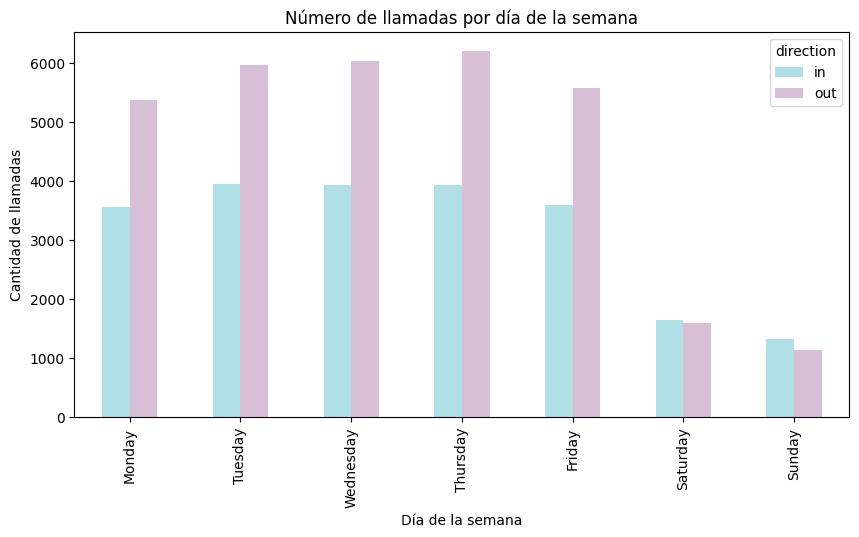

In [20]:
df_full['weekday']=df_full['date'].dt.day_name()
df_full.groupby(['weekday','direction']).size()
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
calls_by_weekday = df_full.groupby(['weekday','direction']).size().reindex(order, level=0)
calls_by_weekday.unstack().plot(kind='bar', figsize=(10,5), color=['powderblue', 'thistle'])
plt.title('Número de llamadas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de llamadas')
plt.show()

Con esta gráfica podemos comprobar que los días más activos son los días entre semana, y que el jueves es el día en el que se presenta mayor actividad. 

#### 2.3 Identificación de valores atípicos

In [21]:
atipico1 = df_full[df_full['call_duration']>df_full['total_call_duration']]
print('La cantidad de call_duration mayor a total_call_duration es de:', len(atipico1))

La cantidad de call_duration mayor a total_call_duration es de: 0


In [22]:
df_full['date'] = df_full['date'].dt.tz_localize(None)
atipico2 = df_full[df_full['date']<df_full['date_start']]
print('La cantidad de date menor a date_start es de:',len(atipico2))

La cantidad de date menor a date_start es de: 0


En este caso, nos interasaba saber si había casos en los que call duration fuera mayor a total call duration ya que esto implicaría un error. Posterior a la ejecución del código podemos identificar que no existen esos supuestos. 

Adicionalmente, nos interesaba saber si había casos en los que la fecha del evento fuera menor a la fecha en la que se registró el usuario, ya que esto también sería un error. Posterior a la ejecución del código podemos identificar que no existen esos supuestos. 

#### 2.4. Correlación entre variables 

Ahora identificaremos si existe relación entre las variables. 

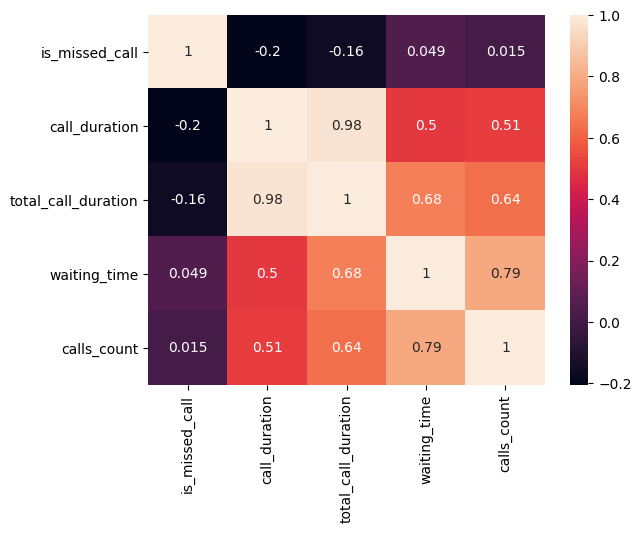

In [23]:
sns.heatmap(df_full[['is_missed_call','call_duration','total_call_duration','waiting_time','calls_count']].corr(),annot=True)
plt.show()

Con este mapa de calor podemos identificar que existen relaciones significativas entre las siguientes variables:
- La duración total de la llamada y el tiempo de espera.
- La duración del tiempo de espera y el conteo de llamadas.

Sobre la primera correlación, podemos identificar que mientras mayor tiempo de espera, la llamada se percibirá como más larga. 
Sobre la segunda correlación, podemos identificar que mientras mayor sea el tiempo de espera, incrementa el número de llamadas realizadas. En este sentido, quizá mientras mayor sea el tiempo de espera, los clientes cuelguen y vuelvan a llamar con la esperanza de ser atendidos con mayor prontitud. 

#### 2.4 Conclusiones del Análisis Exploratorio de Datos

Del análisis exploratorio de datos, identificamos los siguientes hallazgos relevantes: 
1. No existen valores atípicos en la base de datos.
2. El comportamiento de las llamadas es como se esperaría, con un mayor flujo los días entre semana en comparación con los fines de semana.
3. Existe una mayor cantidad de llamadas en las que se entabla una conversación con externos que con internos, lo cual habla de un aparente buen rendimiento general en los operadores.
4. Hay una tendencia a la alta en llamadas, esto quiere decir que incrementó el número de operadores durante el periodo del análisis o que los operadores fueron incrementando su número de llamadas. Esto es importante tenerlo en cuenta pues si no todos los operadores tienen el mismo número de días trabajados habrá un claro sesgo que deberá tratarse para el análisis de datos. 

Ya que tenemos este contexto, podemos continuar con el análisis de la actividad de cada operador. 

### 3. Identificación de operadores ineficaces
#### 3.1. Operadores con mayor cantidad de llamadas perdidas

In [24]:
num_operators = df_calls_clean['operator_id'].nunique()
print('El número total de operadores en CallMeMaybe es:', num_operators)

El número total de operadores en CallMeMaybe es: 1092


In [25]:
df_in_clean = df_in.dropna().reset_index()
df_in_ext = df_in_clean[df_in_clean['internal']==False]

stats_missed = (
    df_in_ext.groupby('operator_id')
    .agg(
        total_calls=('calls_count','sum'),
        missed_calls=('is_missed_call',
                     lambda x:(x*df_in_ext.loc[x.index,'calls_count']).sum())
    )
)
stats_missed['missed_rate'] = stats_missed['missed_calls'] / stats_missed['total_calls']
operators_over_5 = stats_missed[stats_missed['missed_rate']>0.05]

print('La cantidad de operadores que superan el 5% de llamadas perdidas')
print(len(operators_over_5))

La cantidad de operadores que superan el 5% de llamadas perdidas
,59


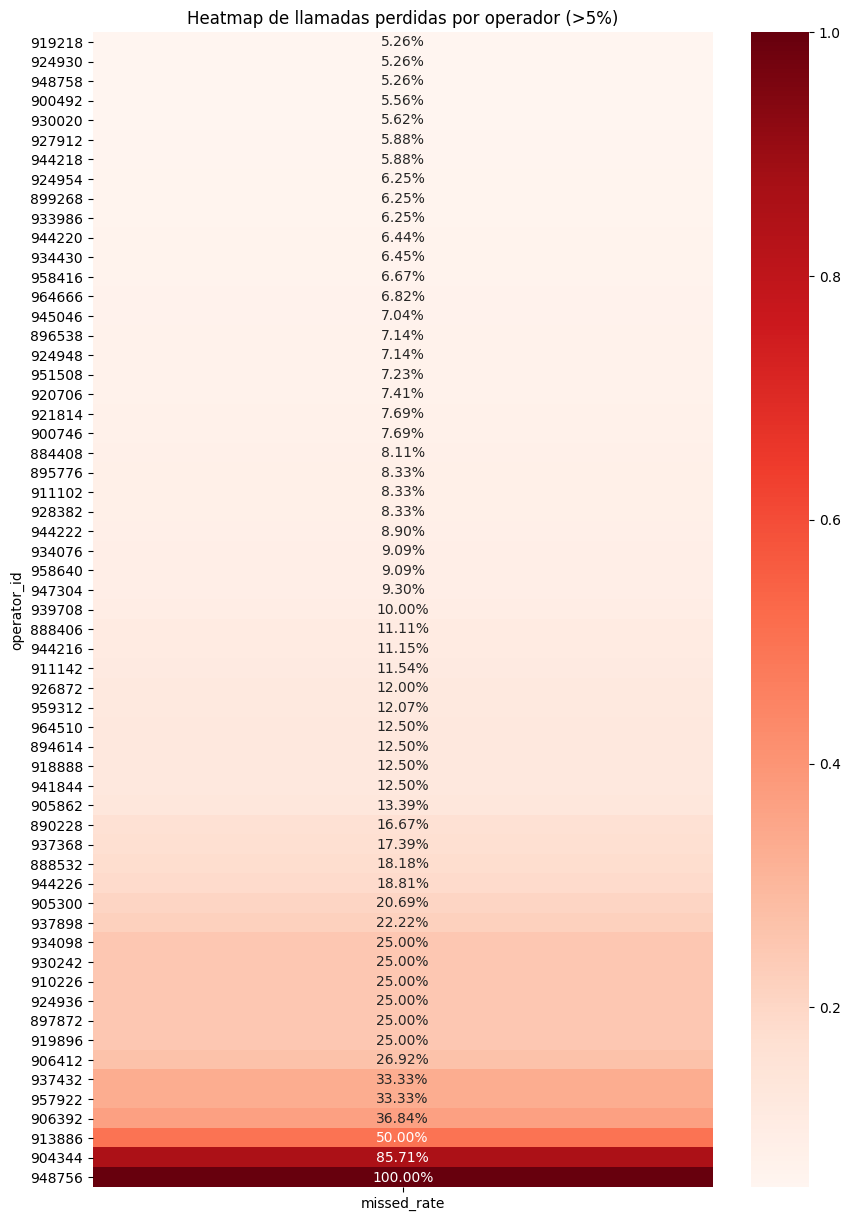

In [26]:
sorted_missed = operators_over_5.sort_values('missed_rate')
plt.figure(figsize=(10,15))
sns.heatmap(sorted_missed[['missed_rate']],annot=True, fmt='.2%', cmap='Reds')
plt.title('Heatmap de llamadas perdidas por operador (>5%)')
plt.show()

Del total de nuestros operadores, únicamente el 5% de ellos rebasan el estándar máximo de que el 5% de sus llamadas sean perdidas, esto es un buen indicador para la empresa, sin embargo, es alarmante existan operadores en los que más del 25% de las llamadas entrantes sean perdidas. Destacan los siguientes operadores: 
- 948756: Con un 100% de llamadas perdidas
- 904344: con un 85% de llamadas perdidas
- 913886: Con un 50% de llamadas perdidas.

Ahora analicemos el comportamiento de los operadores en relación con el tiempo promedio de espera. 

#### 3.2. Tiempo promedio de espera por operador

In [27]:
total_wait_time = df_in_ext['waiting_time'].sum()
total_calls = df_in_ext['calls_count'].sum()
avg_wait_time = total_wait_time / total_calls 
print('El tiempo promedio de espera de CallMeMaybe es: ', avg_wait_time)

El tiempo promedio de espera de CallMeMaybe es:  13.143327793813231


In [28]:
operator_avg_wait = (
    df_in_ext.groupby('operator_id')
    .agg(
        total_waiting_time=('waiting_time','sum'),
        total_calls=('calls_count','sum')
    )
)
operator_avg_wait['avg_waiting_time']=operator_avg_wait['total_waiting_time']/operator_avg_wait['total_calls'] 

operator_over_avg = operator_avg_wait[operator_avg_wait['avg_waiting_time']>60]
print(operator_over_avg)


             total_waiting_time  total_calls  avg_waiting_time
,operator_id                                                   
,899900                      142            2              71.0
,905842                      231            2             115.5
,907174                      623           10              62.3
,917680                      200            2             100.0
,920930                       62            1              62.0
,922114                       61            1              61.0
,960296                      126            2              63.0


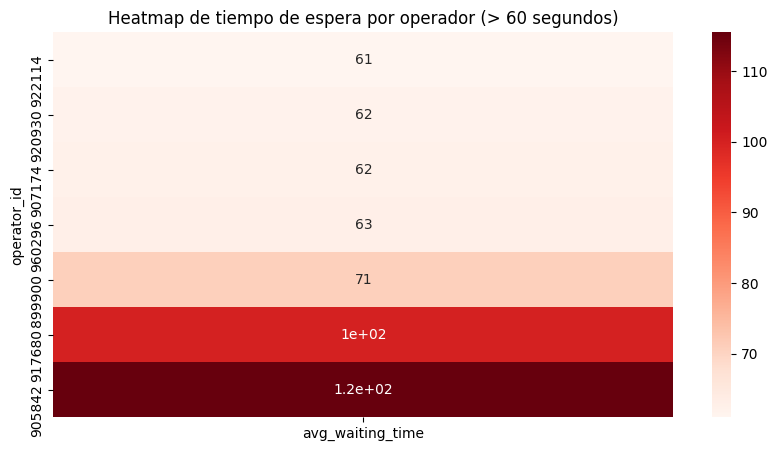

In [29]:
sorted_wait = operator_over_avg.sort_values('avg_waiting_time')
plt.figure(figsize=(10,5))
sns.heatmap(sorted_wait[['avg_waiting_time']],annot=True, cmap='Reds')
plt.title('Heatmap de tiempo de espera por operador (> 60 segundos)')
plt.show()

Podemos identificar que el tiempo de espera promedio de toda la compañía es bajo, pues prácticamente corresponde a 13 segundos. Considerando que la gente comienza a desesperarse después de esperar 5 minutos, pusimos como margen de espera límite un minuto (es decir, 60 segundos). En ese sentido, es favorable identificar que no muchos operadores pasan de los 60 segundos, sin embargo hay unos cuantos que incluso logran duplicar el tiempo de espera. En ese sentido, destacamos a los siguientes operadores como ineficientes: 
- 905842
- 917680
- 899900

Es importante mencionar que este tiempo puede tiene una correlación importante con la cantidad de llamadas asignadas al operador. Por ejemplo, si el operador solo recibió dos llamadas y aún así tuvo un tiempo de espera superior a 60 segundos (como es el caso de nuestros tres operadores señalados), es preocupante y sumamente ineficiente. 

Ahora identifiquemos a los operadores con una menor cantidad de llamadas realizadas. 

#### 3.3. Operadores con menor número de llamadas realizadas

In [30]:
df_out_clean = df_out.dropna().reset_index()
df_out_ext = df_out_clean[df_out_clean['internal']==False]
calls_per_operator_day = df_out_ext.groupby(['operator_id','date'])['calls_count'].sum().reset_index()
days_per_operator = df_out_ext.groupby('operator_id')['date'].nunique().reset_index()
days_per_operator = days_per_operator.rename(columns={'date':'days_count'}) 
total_calls_per_operator = calls_per_operator_day.groupby('operator_id')['calls_count'].sum().reset_index()
operator_summary = pd.merge(total_calls_per_operator, days_per_operator, on = 'operator_id')
operator_summary['avg_calls_per_day'] = (operator_summary['calls_count'] / operator_summary['days_count']).round()
global_avg_calls_per_day = operator_summary['avg_calls_per_day'].mean().round()
print('El promedio global de llamadas diarias de la empresa es de:', global_avg_calls_per_day)

El promedio global de llamadas diarias de la empresa es de: 34.0


Hemos identificado que en un día, en promedio se llevan a cabo 34 llamadas. Ahora, veamos cuantos de nuestros operadores llegan y superan este promedio y cuantos se quedan por debajo de este.

In [31]:
operators_on_avg = operator_summary[operator_summary['avg_calls_per_day']==34]
print('El número de operadores que llegan al promedio de 34 llamadas son:',len(operators_on_avg))
operators_over_avg = operator_summary[operator_summary['avg_calls_per_day']>34]
print('El número de operadores que superan el promedio de 34 llamadas son:',len(operators_over_avg))
operators_under_avg = operator_summary[operator_summary['avg_calls_per_day']<34]
print('El número de operadores que no llegan al promedio de 34 llamadas son:',len(operators_under_avg))

El número de operadores que llegan al promedio de 34 llamadas son: 8
,El número de operadores que superan el promedio de 34 llamadas son: 205
,El número de operadores que no llegan al promedio de 34 llamadas son: 620


Podemos identificar que un número significativo de operadores no llegan al promedio de 34 llamadas al día. Veamos un poco más a profundidad nuesto set de datos. 

In [32]:
print('El promedio más alto de llamadas por día es de', operator_summary['avg_calls_per_day'].max())
print('El promedio más bajo de llamadas por día es de', operator_summary['avg_calls_per_day'].min())
print(operator_summary.sort_values(by='avg_calls_per_day'))
print(df_full['day'].max()-df_full['day'].min())
print(operator_summary['days_count'].max())
print(operator_summary['days_count'].min())

El promedio más alto de llamadas por día es de 906.0
,El promedio más bajo de llamadas por día es de 1.0
,    operator_id  calls_count  days_count  avg_calls_per_day
,434      926872            7           5                1.0
,97       895266            1           1                1.0
,233      907970            1           1                1.0
,235      907982            6           5                1.0
,92       894230            1           1                1.0
,..          ...          ...         ...                ...
,22       885876        64894          97              669.0
,447      929428        24572          33              745.0
,23       885890        64653          80              808.0
,240      908640        16692          19              879.0
,429      925922        21754          24              906.0
,
,[833 rows x 4 columns]
,118 days, 0:00:00
,97
,1


Aquí podemos ver algo importante: los operadores tuvieron diferentes días de registro (variando de 1 a 97 días de registro de los operadores). En ese sentido, para identificar a los operadores ineficientes de una manera objetiva vamos a considerar únicamente a aquellos que tengan registro de más de 41 días, ya que de esta manera los datos son más estables. 

In [33]:
operators_trust = operator_summary[operator_summary['days_count'] > 41]
global_avg_calls_per_day = operators_trust['avg_calls_per_day'].mean().round()
print('El promedio global de llamadas diarias de la empresa es de:', global_avg_calls_per_day)

El promedio global de llamadas diarias de la empresa es de: 43.0


Ya identificamos nuestro nuevo promedio con datos de operadores más estables, ahora verifiquemos qué ususarios llegan al promedio, cuales se pasan del promedio y cuales no llegan al promedio. 

In [34]:
print('El número total de operadores es de',len(operators_trust))
operators_on_avg = operators_trust[operators_trust['avg_calls_per_day']== 43]
print('El número de operadores que llegan al promedio de 43 llamadas son:',len(operators_on_avg))
operators_over_avg = operators_trust[operators_trust['avg_calls_per_day']>43]
print('El número de operadores que superan el promedio de 43 llamadas son:',len(operators_over_avg))
operators_under_avg = operators_trust[operators_trust['avg_calls_per_day']<43]
print('El número de operadores que no llegan al promedio de 43 llamadas son:',len(operators_under_avg))

El número total de operadores es de 86
,El número de operadores que llegan al promedio de 43 llamadas son: 1
,El número de operadores que superan el promedio de 43 llamadas son: 16
,El número de operadores que no llegan al promedio de 43 llamadas son: 69


Demos un vistazo a los operadores que están por debajo de nuestro promedio: 

In [35]:
operators_under_half_avg = operators_under_avg[operators_under_avg['avg_calls_per_day']<21]
print(operators_under_half_avg)
print('El total de operadores que tienen menos de la mitad del promedio de llamadas es:',len(operators_under_half_avg))

    operator_id  calls_count  days_count  avg_calls_per_day
,8        882684          711          58               12.0
,18       884412          822          54               15.0
,25       887276          673          69               10.0
,38       889410         1103          87               13.0
,39       889754         1341          67               20.0
,44       890402         1379          74               19.0
,45       890404         1479          75               20.0
,46       890406         1345          72               19.0
,47       890410         1348          72               19.0
,48       890412         1343          72               19.0
,49       890416         1380          73               19.0
,50       890420          746          43               17.0
,54       891152          286          55                5.0
,55       891154          600          70                9.0
,57       891158          303          64                5.0
,58       891160         

#### 3.4. Operadores ineficientes

Ahora que hemos identificado a los operadores más ineficientes de cada sección, podemos identificar a los operadores más ineficientes identificando si hay algunos que compartan las tres métricas: mayor cantidad de llamadas perdidas, mayor tiempo de espera y menor número de llamadas perdidas. 

In [36]:
operators_over_5_2 = operators_over_5.copy().reset_index()
operator_over_avg_2 = operator_over_avg.copy().reset_index()
operators_under_avg_2 = operators_under_avg.copy().reset_index()

In [37]:
df_full_clean = df_full.dropna().reset_index()
operadores_ineficientes = df_full_clean[
    (df_full_clean['operator_id'].isin(operators_over_5_2['operator_id'])) &
    (df_full_clean['operator_id'].isin(operator_over_avg_2['operator_id'])) &
    (df_full_clean['operator_id'].isin(operators_under_avg_2['operator_id']))
    ]
print('La cantidad de operadores ineficintes que comparten las tres métricas es de:', operadores_ineficientes['operator_id'].nunique())

La cantidad de operadores ineficintes que comparten las tres métricas es de: 0


De este primer filtrado, podemos identificar que no hay operadores que incurran en ineficiencia en las tres métricas. Ahora, veamos si hay operadores que incurran en mayor cantidad de llamadas perdidas y mayor tiempo de espera. 

In [38]:
operadores_ineficientes_2 = df_full_clean[
    (df_full_clean['operator_id'].isin(operators_over_5_2['operator_id'])) &
    (df_full_clean['operator_id'].isin(operator_over_avg_2['operator_id'])) ]
print('La cantidad de operadores que tienen la mayor cantidad de llamadas perdidas y un tiempo de espera superior a 60 segundos es de:', operadores_ineficientes_2['operator_id'].nunique())

La cantidad de operadores que tienen la mayor cantidad de llamadas perdidas y un tiempo de espera superior a 60 segundos es de: 0


Tampoco tenemos ese tipo de operadores. Ahora identifiquemos si hay operadores que incurran en mayor cantidad de llamadas perdidas y menor cantidad de llamadas realizadas. 

In [39]:
operadores_ineficientes_3 = df_full_clean[
    (df_full_clean['operator_id'].isin(operators_over_5_2['operator_id'])) &
    (df_full_clean['operator_id'].isin(operators_under_avg_2['operator_id']))]

print('La cantidad de operadores que tienen la mayor cantidad de llamadas perdidas y un menor número de llamadas realizadas es de:', operadores_ineficientes_3['operator_id'].nunique())
print('El operador en cuestión es:',operadores_ineficientes_3['operator_id'].unique())

La cantidad de operadores que tienen la mayor cantidad de llamadas perdidas y un menor número de llamadas realizadas es de: 1
,El operador en cuestión es: ['900492']


Finalmente, identificaremos si existen operadores que excedan un tiempo de espera de 60 segundos y que tengan un número bajo de llamadas realizadas. 

In [40]:
operadores_ineficientes_4 = df_full_clean[
    (df_full_clean['operator_id'].isin(operator_over_avg_2['operator_id'])) &
    (df_full_clean['operator_id'].isin(operators_under_avg_2['operator_id']))]

print('La cantidad de operadores que exteden un tiempo de espera de 60 segundos y tienen un bajo número de llamadas realizadas es de:',operadores_ineficientes_4['operator_id'].nunique())
print('El operador en cuestión es:',operadores_ineficientes_3['operator_id'].unique())

La cantidad de operadores que exteden un tiempo de espera de 60 segundos y tienen un bajo número de llamadas realizadas es de: 1
,El operador en cuestión es: ['900492']


Podemos establecer que uno de los operadores más ineficientes es el identificado con el número 900492. Sin embargo, no podemos establecer que únicamente dicho operador presenta cifras poco favorables, pues si bien los operadores no comparten una baja en las tres métricas para considerarlos completamente ineficientes, hay operadores que en cada categoría sobresalen por su ineficiencia. A continuación se mostrarán tablas en forma de resumen de cada categoría. 

In [41]:
print('Los operadores cuyas llamadas perdidas superan el 5% de sus llamadas realizadas son:')
operators_over_5_2.sort_values(by='missed_rate',ascending = False).head(10)

Los operadores cuyas llamadas perdidas superan el 5% de sus llamadas realizadas son:


,operator_id,total_calls,missed_calls,missed_rate
50,948756,1,1,1.000000
11,904344,7,6,0.857143
19,913886,2,1,0.500000
14,906392,19,7,0.368421
39,937432,3,1,0.333333
53,957922,3,1,0.333333
15,906412,26,7,0.269231
36,934098,4,1,0.250000
22,919896,8,2,0.250000
7,897872,4,1,0.250000


In [42]:
print('Los operadores cuyo tiempo de espera supera los 60 segundos son:')
operator_over_avg_2.sort_values(by='avg_waiting_time', ascending = False)

Los operadores cuyo tiempo de espera supera los 60 segundos son:


,operator_id,total_waiting_time,total_calls,avg_waiting_time
1,905842,231,2,115.5
3,917680,200,2,100.0
0,899900,142,2,71.0
6,960296,126,2,63.0
2,907174,623,10,62.3
4,920930,62,1,62.0
5,922114,61,1,61.0


In [43]:
print('Los operadores que realizan menos de 43 llamadas al día son:')
operators_under_avg_2.sort_values(by='avg_calls_per_day').head(53)

Los operadores que realizan menos de 43 llamadas al día son:


,index,operator_id,calls_count,days_count,avg_calls_per_day
36,154,901584,185,54,3.0
44,187,905104,146,43,3.0
43,182,904038,230,59,4.0
60,310,918390,262,62,4.0
35,149,900894,223,59,4.0
31,138,900492,258,54,5.0
21,60,891166,275,58,5.0
19,57,891158,303,64,5.0
17,54,891152,286,55,5.0
26,104,896016,207,45,5.0


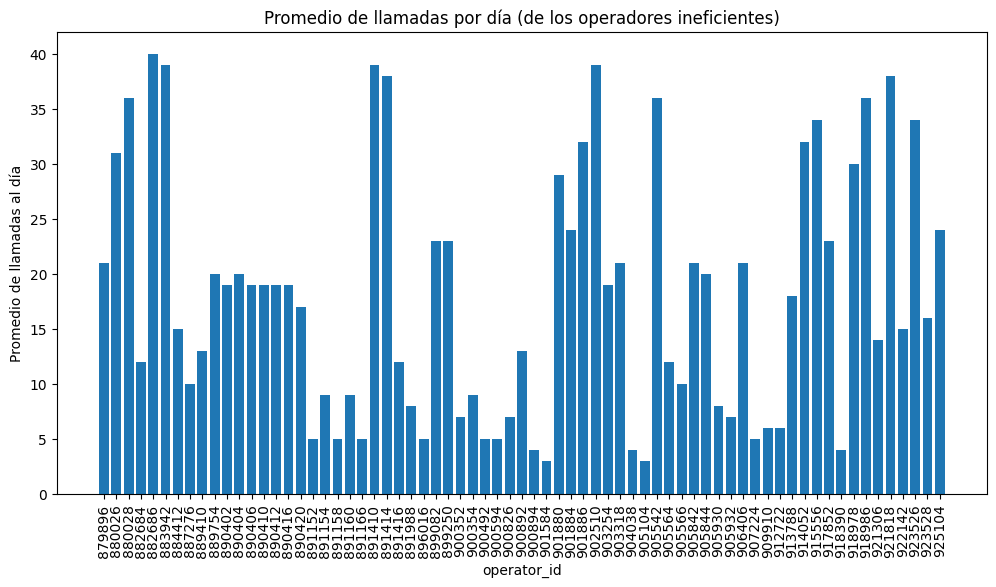

In [47]:
plt.figure(figsize=(12,6))
plt.bar(operators_under_avg_2['operator_id'], operators_under_avg_2['avg_calls_per_day'])
plt.xlabel('operator_id')
plt.ylabel('Promedio de llamadas al día')
plt.title('Promedio de llamadas por día (de los operadores ineficientes)')
plt.xticks(rotation = 90)
plt.show()

#### 3.5. Conclusiones 
Los operadores son ineficientes en diferentes áreas. Derivado del análisis podemos resaltar los siguientes hallazgos: 
1. Valdría la pena identificar si todos los operadores tienen la atribución de recibir y realizar llamadas, pues se identificaron operadores que no realizan llamadas así como operadores que no reciben llamadas.
2. Hay una cantidad significativa de operadores que no llega al promedio de llamadas al día, pero esto puede deberse a inconsistencias en los registros de las bases de datos que también será necesario ajustar para futuros análisis.
3. En general los tiempos de espera de los operadores no son malos, pues en su mayoría no exceden de los 60 segundos, lo cual es un tiempo aceptable para atender una llamada evitando que el cliente se desespere.
4. También hay un número significativo de operadores que superan la brecha de 5% de llamadas perdidas del total de sus llamadas, por lo que será importante identificar a qué se debe esto. 

### 4. Prueba de Hipótesis: Impacto de la Conformación de los Datos en el Análisis

La calidad de los datos es un factor crucial en cualquier análisis, ya que puede influir significativamente en los resultados y las conclusiones. En este estudio, se analizará cómo ciertos problemas en la base de datos de telecomunicaciones, como valores faltantes en la columna operator_id, inconsistencias en la columna calls_count y el desbalance en el número de registros por operador, afectan el análisis de métricas clave como la duración de las llamadas y el porcentaje de llamadas perdidas.

La hipótesis principal es que una base de datos más "limpia", corregida de estos problemas, generará resultados diferentes a los obtenidos con los datos originales. Para comprobar esto, se compararán las métricas del análisis utilizando dos versiones del dataset: una con los datos originales y otra procesada, donde se ajustan los valores faltantes, se normaliza calls_count y se balancean los registros por operador.

En ese sentido nuestra hipótesis nula es: **Los ajustes en la calidad de los datos no afecta significativamente las métricas del análisis**

Mientras que nuestra hipóresis alternativa es: **Los ajustes en la calidd de los datos sí afecta significativamente las métricas del análisis**

In [45]:
df_clean = df_calls.dropna(subset=['operator_id']).copy()
df_clean['call_duration_adjusted'] = df_clean['call_duration'] / df_clean['calls_count']

t_stat, p_value = stats.ttest_ind(df_calls['call_duration'],df_clean['call_duration_adjusted'])

print('Estadístico t:',t_stat)
print('Valor p:',p_value)

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: La calidad de los datos afecta significativamente la duración de las llamadas.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que la calidad de los datos afecta la duración de las llamadas.")

Estadístico t: 45.198912181049586
,Valor p: 0.0
,Rechazamos la hipótesis nula: La calidad de los datos afecta significativamente la duración de las llamadas.


### 5. Conclusiones 
La exploración inicial permitió identificar problemas importantes en la estructura del dataset, como tipos de datos incorrectos, columnas con valores faltantes y posibles inconsistencias en llamadas completadas sin operador asignado. Este diagnóstico temprano fue clave para orientar un proceso de limpieza adecuado y asegurar mayor confiabilidad en los análisis posteriores.

El desempeño no es uniforme entre operadores: se observan diferencias en duración, fallas y llamadas incompletas. Algunos operadores concentran más errores, lo que afecta la experiencia del usuario y puede influir en el churn. Esto confirma que el operador es un factor indispensable para segmentar el comportamiento del cliente y entender variaciones en la calidad del servicio.

Es importante mencionar que la calidad de los datos también afecta significativamente en el procesamiento y análisis de los mismos. En ese sentido, en este proyecto se procuró que los valores ausentes, los segsos y las diferencias en los registros de los operadores no influyera en el análisis. 

### 6. Líneas de acción 
#### 1. Sobre la calidad de los datos
Para futuros análisis se es necesario mejorar la base de datos. En este sentido, con el fin de evitar sesgos y mejorar la homojeanización de los datos se sugiere: 
- Que el registro de los datos sea por evento (por llamada).
- Abarcar un periodo de tiempo concreto (por ejemplo, un mes, un bimestre o un trimestre).
- No agregar operadores nuevos, únicamente considerar a los operadores con los que se inicia la recopilación de datos. En ese sentido será importante que desde el inicio de la recopilación de los datos se considere a la mayor cantidad de operadores posible.

#### 2. Reducción de los tiempos de espera
En general los tiempos de espera de cada operador no son malos. Sin embargo, podemos reducirlos llevando a cabo las siguientes acciones: 
- Optimizar el ruteo de llamadas para equilibrar la carga entre los operadores.
- Implementar alertas en tiempo real cuando el tiempo de conexión supere un tiempo determinado.

#### 3. Reducir el número de llamadas perdidas 
- Priorizar intervenciones en operadores con tasa elevadas de llamadas perdidas.
- Mejorar la distribución entre operadores para disminuir llamadas perdidas.

#### 4. Mejorar la cantidad de llamadas salientes 
- Asegurar que los usuarios cuenten con suficiente cobertura y estabilidad antes del inicio de la llamada.

## Liga a la presentación

https://1drv.ms/b/c/35c114640b8f64c8/ER_CqU1qiEdEusFRgy078AEBffTke4mFUEPRWwQ906wfNQ?e=WBc6ig

## Liga a dashboard: 
https://public.tableau.com/views/AnlisisCallMeMaybe/Dashboard1?:language=es-ES&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link


## Referencias: 
<small> 1. Salesforce. (n.d.). ¿Qué es la telefonía?. Salesforce. Recuperado el 6 de noviembre de 2025, de https://www.salesforce.com/es/resources/articles/what-is-telephony/ </small>

<small> 2. Rodríguez, S. (2023, marzo 9). Industria de centros de atención creció 12 % en 2023: IMT. Milenio. Recuperado de https://www.milenio.com/negocios/industria-centros-atencion-crecio-12-2023-imt </small>

<small> 
3. Lucido-Balestrieri, S. (2025, 20 de mayo). KPIs para call center: Los 10 indicadores clave que deberías estar midiendo. CloudTalk. https://www.cloudtalk.io/es/blog/los-10-kpi-mas-importantes-de-call-center-que-debes-controlar/ </small>

<small> 4. Patten, V. (2023, 11 de agosto). Discover the average call wait time in call centers and how to reduce yours. EvaluAgent. Recuperado de https://www.evaluagent.com/knowledge-hub/average-call-wait-times-and-how-to-reduce-it/ </small>

<small>5. VCC Live. (s. f.). Average Wait Time – Formula & How to improve. Recuperado de https://vcc.live/call-center-kpis/average-wait-time/</small>

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Ximena! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Diagnosticaste bien el estado inicial de los datos con info(), head() y conteos de nulos.<br>
• Estandarizaste tipos de datos clave y documentaste tus decisiones de limpieza.<br>
• Justificaste con lógica de negocio la exclusión de registros sin operator_id para evaluar desempeño individual.<br>
• Creaste métricas útiles como waiting_time y las aplicaste con criterio.<br>
• Construiste visualizaciones comparativas (in vs out) que aportan contexto operativo.<br>
• Analizaste temporalidad por día y por día de semana para entender patrones de actividad.<br>
• Verificaste la calidad del dataset con checks de atípicos y consistencia temporal.<br>
• Calculaste tasas de abandono ponderadas por calls_count, una excelente práctica.<br>
• Normalizaste productividad por días activos, mejorando la comparación entre operadores.<br>
• Cerraste con recomendaciones accionables y materiales de apoyo (presentación y dashboard).<br>
<br>
¡Felicidades!
</div>